In [3]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import re

In [4]:
# set parameters
np.random.seed(0)
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
data_dir = "C:/Users/Filip/Desktop/PW/2 semestr/Deep Learning/pro1"

batch_size = 64
epochs = 25

steps_per_epoch = 90000
steps_per_epoch = min(steps_per_epoch, 90000/batch_size)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set parameters
np.random.seed(0)
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
data_dir = "C:/Users/Filip/Desktop/PW/2 semestr/Deep Learning/pro1"

batch_size = 64
epochs = 25

steps_per_epoch = 90000 // batch_size   # Corrected the division to use integer division

# Create a single ImageDataGenerator for both training and testing sets
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1.0 / 255  # Add the rescaling factor here
)

# Create generators for the training and test sets
train_generator = datagen.flow_from_directory(
    data_dir + "/train",
    target_size=(32, 32),  # Resize images to this size
    batch_size=batch_size,  # Number of images to load at each iteration
    class_mode="categorical",  # Type of classification ('binary' or 'categorical')
)

test_generator = datagen.flow_from_directory(
    data_dir + "/test",
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode="categorical",
)

# Now you can use train_generator and test_generator for training and evaluation


Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


In [12]:
import tensorflow_addons as tfa

In [14]:
def mixup(x, y, alpha=0.2):
    """Apply the mixup augmentation to a batch of images and labels."""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = tf.shape(x)[0]
    index = tf.random.shuffle(tf.range(batch_size))

    mixed_x = lam * x + (1 - lam) * tf.gather(x, index)
    mixed_y = lam * y + (1 - lam) * tf.gather(y, index)
    return mixed_x, mixed_y

In [7]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation="relu", input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])


In [16]:
epochs = 30
for epoch in range(epochs):
    print("\nEpoch", epoch + 1, "/", epochs)
    progbar = tf.keras.utils.Progbar(steps_per_epoch)

    for step in range(steps_per_epoch):
        x_batch, y_batch = next(train_generator)

        # Apply mixup
        x_batch, y_batch = mixup(x_batch, y_batch, alpha=0.2)

        # Perform a training step
        loss, accuracy = model.train_on_batch(x_batch, y_batch)
        progbar.update(step + 1, values=[("loss", loss), ("acc", accuracy)])


Epoch 1 / 30
1406/1406 [==============================] - 120s 80ms/step - loss: 2.2314 - acc: 0.2457

Epoch 2 / 30
 307/1406 [=====>........................] - ETA: 1:25 - loss: 1.9859 - acc: 0.2946

KeyboardInterrupt: 

In [21]:
import numpy as np
import tensorflow as tf

def cutmix(images, labels, alpha=1.0):
    # Get a random lambda value
    lam = np.random.beta(alpha, alpha)
    batch_size = tf.shape(images)[0]
    index = tf.random.shuffle(tf.range(batch_size))

    # Choose a random image to mix with
    bbx1, bby1, bbx2, bby2 = rand_bbox(images.shape, lam)

    # Create mask and apply it to the images
    mask_width = bbx2 - bbx1
    mask_height = bby2 - bby1
    mask = np.full((images.shape[1], images.shape[2], images.shape[3]), fill_value=lam, dtype=np.float32)
    mask[bby1:bby2, bbx1:bbx2, :] = 1.0 - lam

    mask = tf.convert_to_tensor(mask)
    mask = tf.reshape(mask, [1, images.shape[1], images.shape[2], images.shape[3]]) # Reshape mask to be broadcastable
    mixed_images = images * mask + tf.gather(images, index) * (1 - mask)

    # Adjust lambda according to the pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.shape[1] * images.shape[2]))
    mixed_labels = lam * labels + (1 - lam) * tf.gather(labels, index)
    return mixed_images, mixed_labels



def rand_bbox(size, lam):
    W = size[2]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)  # Change to Python's built-in int
    cut_h = int(H * cut_rat)  # Change to Python's built-in int

    # Uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2





Epoch 1 / 30
 330/1407 [======>.......................] - ETA: 1:13 - loss: 1.7871 - accuracy: 0.3649

KeyboardInterrupt: 

In [23]:
# Training loop
epochs = 30
validation_loss = []
validation_accuracy = []

for epoch in range(epochs):
    print("\nEpoch", epoch + 1, "/", epochs)
    progbar = tf.keras.utils.Progbar(steps_per_epoch)

    for step in range(steps_per_epoch):
        x_batch, y_batch = next(train_generator)

        # Apply CutMix
        x_batch, y_batch = cutmix(x_batch, y_batch, alpha=0.2)

        # Perform a training step
        loss, accuracy = model.train_on_batch(x_batch, y_batch)
        progbar.update(step + 1, values=[("loss", loss), ("acc", accuracy)])

    # Validation step at the end of the epoch
    val_loss, val_acc = model.evaluate(test_generator)
    validation_loss.append(val_loss)
    validation_accuracy.append(val_acc)
    print("Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(val_loss, val_acc))


Epoch 1 / 30
1407/1407 [==============================] - 87s 62ms/step - loss: 1.7032 - accuracy: 0.3926
Validation Loss: 1.7032, Validation Accuracy: 0.3926

Epoch 2 / 30
1407/1407 [==============================] - 61s 44ms/step - loss: 1.7117 - accuracy: 0.3766
Validation Loss: 1.7117, Validation Accuracy: 0.3766

Epoch 3 / 30
1407/1407 [==============================] - 60s 42ms/step - loss: 1.6379 - accuracy: 0.4271
Validation Loss: 1.6379, Validation Accuracy: 0.4271

Epoch 4 / 30
1407/1407 [==============================] - 60s 43ms/step - loss: 1.6062 - accuracy: 0.4403
Validation Loss: 1.6062, Validation Accuracy: 0.4403

Epoch 5 / 30
1407/1407 [==============================] - 60s 43ms/step - loss: 1.5973 - accuracy: 0.4392
Validation Loss: 1.5973, Validation Accuracy: 0.4392

Epoch 6 / 30
1407/1407 [==============================] - 62s 44ms/step - loss: 1.5259 - accuracy: 0.4611
Validation Loss: 1.5259, Validation Accuracy: 0.4611

Epoch 7 / 30
1407/1407 [===============

In [24]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation="relu", input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])


In [25]:
# Training loop
epochs = 30
validation_loss_2 = []
validation_accuracy_2 = []

for epoch in range(epochs):
    print("\nEpoch", epoch + 1, "/", epochs)
    progbar = tf.keras.utils.Progbar(steps_per_epoch)

    for step in range(steps_per_epoch):
        x_batch, y_batch = next(train_generator)

        # Apply CutMix
        x_batch, y_batch = cutmix(x_batch, y_batch, alpha=0.4)

        # Perform a training step
        loss, accuracy = model.train_on_batch(x_batch, y_batch)
        progbar.update(step + 1, values=[("loss", loss), ("acc", accuracy)])

    # Validation step at the end of the epoch
    val_loss, val_acc = model.evaluate(test_generator)
    validation_loss_2.append(val_loss)
    validation_accuracy_2.append(val_acc)
    print("Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(val_loss, val_acc))


Epoch 1 / 30
1407/1407 [==============================] - 59s 42ms/step - loss: 1.9456 - accuracy: 0.2874
Validation Loss: 1.9456, Validation Accuracy: 0.2874

Epoch 2 / 30
1407/1407 [==============================] - 59s 42ms/step - loss: 1.8719 - accuracy: 0.3277
Validation Loss: 1.8719, Validation Accuracy: 0.3277

Epoch 3 / 30
1407/1407 [==============================] - 60s 43ms/step - loss: 1.8004 - accuracy: 0.3655
Validation Loss: 1.8004, Validation Accuracy: 0.3655

Epoch 4 / 30
1407/1407 [==============================] - 63s 45ms/step - loss: 1.7128 - accuracy: 0.3950
Validation Loss: 1.7128, Validation Accuracy: 0.3950

Epoch 5 / 30
1407/1407 [==============================] - 61s 43ms/step - loss: 1.6751 - accuracy: 0.4007
Validation Loss: 1.6751, Validation Accuracy: 0.4007

Epoch 6 / 30
1407/1407 [==============================] - 59s 42ms/step - loss: 1.7045 - accuracy: 0.3959
Validation Loss: 1.7045, Validation Accuracy: 0.3959

Epoch 7 / 30
1407/1407 [===============

In [26]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation="relu", input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])


In [27]:
# Training loop
epochs = 40
validation_loss_3 = []
validation_accuracy_3 = []

for epoch in range(epochs):
    print("\nEpoch", epoch + 1, "/", epochs)
    progbar = tf.keras.utils.Progbar(steps_per_epoch)

    for step in range(steps_per_epoch):
        x_batch, y_batch = next(train_generator)

        # Apply CutMix
        x_batch, y_batch = cutmix(x_batch, y_batch, alpha=0.6)

        # Perform a training step
        loss, accuracy = model.train_on_batch(x_batch, y_batch)
        progbar.update(step + 1, values=[("loss", loss), ("acc", accuracy)])

    # Validation step at the end of the epoch
    val_loss, val_acc = model.evaluate(test_generator)
    validation_loss_3.append(val_loss)
    validation_accuracy_3.append(val_acc)
    print("Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(val_loss, val_acc))


Epoch 1 / 40
1407/1407 [==============================] - 60s 43ms/step - loss: 1.9548 - accuracy: 0.2983
Validation Loss: 1.9548, Validation Accuracy: 0.2983

Epoch 2 / 40
1407/1407 [==============================] - 61s 43ms/step - loss: 1.8941 - accuracy: 0.3218
Validation Loss: 1.8941, Validation Accuracy: 0.3218

Epoch 3 / 40
1407/1407 [==============================] - 61s 44ms/step - loss: 1.8245 - accuracy: 0.3577
Validation Loss: 1.8245, Validation Accuracy: 0.3577

Epoch 4 / 40
1407/1407 [==============================] - 63s 45ms/step - loss: 1.8011 - accuracy: 0.3588
Validation Loss: 1.8011, Validation Accuracy: 0.3588

Epoch 5 / 40
1407/1407 [==============================] - 60s 43ms/step - loss: 1.7456 - accuracy: 0.3919
Validation Loss: 1.7456, Validation Accuracy: 0.3919

Epoch 6 / 40
1407/1407 [==============================] - 60s 43ms/step - loss: 1.7842 - accuracy: 0.3724
Validation Loss: 1.7842, Validation Accuracy: 0.3724

Epoch 7 / 40
1407/1407 [===============

In [1]:
min_length = min(len(validation_accuracy), len(validation_accuracy_2), len(validation_accuracy_3))

# Truncate lists to the smallest length if necessary.
validation_accuracy = validation_accuracy[:min_length]
validation_accuracy_2 = validation_accuracy_2[:min_length]
validation_accuracy_3 = validation_accuracy_3[:min_length]

# Plotting the validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(range(1, min_length+1), validation_accuracy, label='Cutmix alpha=0.2', marker='o')
plt.plot(range(1, min_length+1), validation_accuracy_2, label='Cutmix alpha=0.4', marker='o')
plt.plot(range(1, min_length+1), validation_accuracy_3, label='Cutmix alpha=0.6', marker='o')

# Adding titles and labels
plt.title('Comparison of Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'validation_accuracy' is not defined

In [35]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation="relu", input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.6),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])


In [36]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, save_weights_only=True)

# Train the model using the generators
model.fit(train_generator,
          epochs=60,
          validation_data=test_generator,
          callbacks=[reduce_lr, early_stop, checkpoint])

Epoch 1/25
1407/1407 [==============================] - 85s 60ms/step - loss: 2.1400 - accuracy: 0.3002 - val_loss: 1.6145 - val_accuracy: 0.4132
Epoch 2/25
1407/1407 [==============================] - 54s 38ms/step - loss: 1.6467 - accuracy: 0.4052 - val_loss: 1.4396 - val_accuracy: 0.4687
Epoch 3/25
1407/1407 [==============================] - 55s 39ms/step - loss: 1.4832 - accuracy: 0.4622 - val_loss: 1.4142 - val_accuracy: 0.4825
Epoch 4/25
1407/1407 [==============================] - 54s 38ms/step - loss: 1.3797 - accuracy: 0.5009 - val_loss: 1.3117 - val_accuracy: 0.5262
Epoch 5/25
1407/1407 [==============================] - 55s 39ms/step - loss: 1.2973 - accuracy: 0.5303 - val_loss: 1.2302 - val_accuracy: 0.5545
Epoch 6/25
1407/1407 [==============================] - 54s 38ms/step - loss: 1.2341 - accuracy: 0.5542 - val_loss: 1.2095 - val_accuracy: 0.5642
Epoch 7/25
1407/1407 [==============================] - 55s 39ms/step - loss: 1.1683 - accuracy: 0.5782 - val_loss: 1.2224 -

In [31]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation="relu", input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.7),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])


In [28]:
from tensorflow.keras import models

# Assuming 'model' is your original model
layer_outputs = [layer.output for layer in model.layers[:12]]  # Extract the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)  # Creates a model that will return these outputs, given the model input


In [32]:
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img("C:/Users/Filip/Desktop/PW/2 semestr/Deep Learning/pro1/valid/airplane/cifar10-train-49.png", target_size=(32, 32))  # Load the image and resize it
img_tensor = image.img_to_array(img)  # Convert it to a numpy array
img_tensor = np.expand_dims(img_tensor, axis=0)  # Add the batch dimension
img_tensor /= 255.  # Model expects normalized data


In [33]:
activations = activation_model.predict(img_tensor)


1/1 [==============================] - 0s 391ms/step


(1, 30, 30, 64)


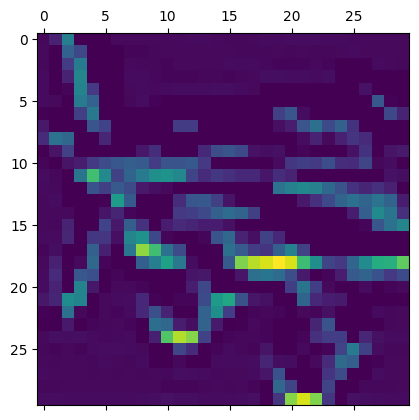

In [37]:
import matplotlib.pyplot as plt

first_layer_activation = activations[0]  # Activations for the first layer
print(first_layer_activation.shape)  # Shape will be (1, 30, 30, 64) for the first Conv2D layer

# Choose a filter index
channel = 0  # Index of the filter to visualize

# Visualize the activation
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')
plt.show()


In [39]:
!pip install visualkeras

   ---------------------------------------- 0.0/45.0 kB ? eta -:--:--
   ---------------------------------------- 45.0/45.0 kB 1.1 MB/s eta 0:00:00


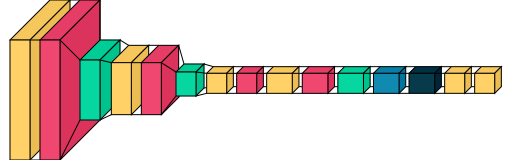

In [40]:
import visualkeras
visualkeras.layered_view(model)

In [52]:
!pip install keras.utils

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2654 sha256=e6fa4e102c96deb15078d92f55b3765d39cf637f813eb3602f8a5c13c5fb7bce
  Stored in directory: c:\users\filip\appdata\local\pip\cache\wheels\5c\c0\b3\0c332de4fd71f3733ea6d61697464b7ae4b2b5ff0300e6ca7a
Successfully built keras.utils


In [55]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [51]:
visualkeras.layered_view(model, legend=True) # without custom font
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(model, legend=True) # selected font

AttributeError: 'FreeTypeFont' object has no attribute 'getsize'

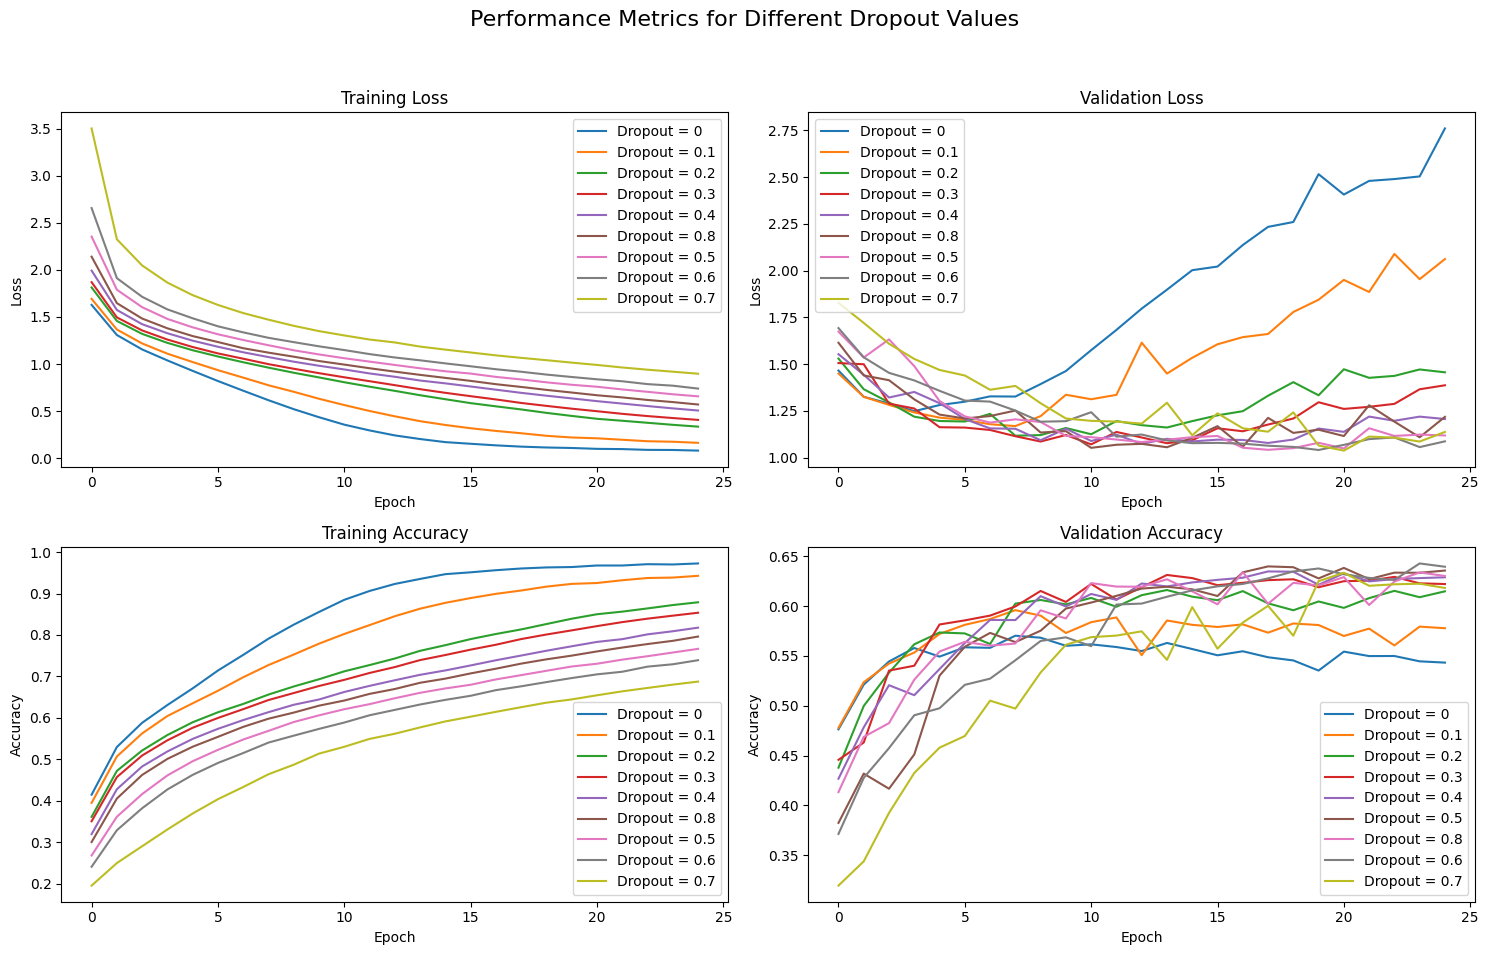

In [41]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plotting Training Loss
axs[0, 0].plot(history_1.history['loss'], label='Dropout = 0')
axs[0, 0].plot(history_2.history['loss'], label='Dropout = 0.1')
axs[0, 0].plot(history_3.history['loss'], label='Dropout = 0.2')
axs[0, 0].plot(history_4.history['loss'], label='Dropout = 0.3')
axs[0, 0].plot(history_5.history['loss'], label='Dropout = 0.4')
axs[0, 0].plot(history_5_5.history['loss'], label='Dropout = 0.8')
axs[0, 0].plot(history_6.history['loss'], label='Dropout = 0.5')
axs[0, 0].plot(history_7.history['loss'], label='Dropout = 0.6')
axs[0, 0].plot(history_8.history['loss'], label='Dropout = 0.7')

axs[0, 0].set_title('Training Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

# Plotting Validation Loss
axs[0, 1].plot(history_1.history['val_loss'], label='Dropout = 0')
axs[0, 1].plot(history_2.history['val_loss'], label='Dropout = 0.1')
axs[0, 1].plot(history_3.history['val_loss'], label='Dropout = 0.2')
axs[0, 1].plot(history_4.history['val_loss'], label='Dropout = 0.3')
axs[0, 1].plot(history_5.history['val_loss'], label='Dropout = 0.4')
axs[0, 1].plot(history_5_5.history['val_loss'], label='Dropout = 0.8')
axs[0, 1].plot(history_6.history['val_loss'], label='Dropout = 0.5')
axs[0, 1].plot(history_7.history['val_loss'], label='Dropout = 0.6')
axs[0, 1].plot(history_8.history['val_loss'], label='Dropout = 0.7')

axs[0, 1].set_title('Validation Loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()

# Plotting Training Accuracy
axs[1, 0].plot(history_1.history['accuracy'], label='Dropout = 0')
axs[1, 0].plot(history_2.history['accuracy'], label='Dropout = 0.1')
axs[1, 0].plot(history_3.history['accuracy'], label='Dropout = 0.2')
axs[1, 0].plot(history_4.history['accuracy'], label='Dropout = 0.3')
axs[1, 0].plot(history_5.history['accuracy'], label='Dropout = 0.4')
axs[1, 0].plot(history_5_5.history['accuracy'], label='Dropout = 0.8')
axs[1, 0].plot(history_6.history['accuracy'], label='Dropout = 0.5')
axs[1, 0].plot(history_7.history['accuracy'], label='Dropout = 0.6')
axs[1, 0].plot(history_8.history['accuracy'], label='Dropout = 0.7')

axs[1, 0].set_title('Training Accuracy')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()

# Plotting Validation Accuracy
axs[1, 1].plot(history_1.history['val_accuracy'], label='Dropout = 0')
axs[1, 1].plot(history_2.history['val_accuracy'], label='Dropout = 0.1')
axs[1, 1].plot(history_3.history['val_accuracy'], label='Dropout = 0.2')
axs[1, 1].plot(history_4.history['val_accuracy'], label='Dropout = 0.3')
axs[1, 1].plot(history_5.history['val_accuracy'], label='Dropout = 0.4')
axs[1, 1].plot(history_6.history['val_accuracy'], label='Dropout = 0.5')
axs[1, 1].plot(history_5_5.history['val_accuracy'], label='Dropout = 0.8')
axs[1, 1].plot(history_7.history['val_accuracy'], label='Dropout = 0.6')
axs[1, 1].plot(history_8.history['val_accuracy'], label='Dropout = 0.7')

axs[1, 1].set_title('Validation Accuracy')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()

# Adjust layout and set an overall title
fig.suptitle('Performance Metrics for Different Dropout Values', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()